In [35]:
%load_ext autoreload
%autoreload 2
import os
import random
import warnings
from datetime import datetime
#import gdown

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                generate_enriched_gp_info_plots)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!which python

/work/rwth1209/enviroments/nichecompass/bin/python


In [37]:
### Dataset ###
dataset = "heart"
species = "human"
spatial_key = "spatial"
n_neighbors = 4

### Model ###
# AnnData Keys
counts_key = "counts"
adj_key = "connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
conv_layer_encoder = "gcnconv" # change to "gatv2conv" if enough compute and memory
active_gp_thresh_ratio = 0.01

# Trainer
n_epochs = 400
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_l1_masked = 0. # increase if gene selection desired
lambda_l1_addon = 100.
edge_batch_size = 1024 # increase if more memory available
n_sampled_neighbors = 4
use_cuda_if_available = True

### Analysis ###
cell_type_key = "cell_type"
latent_leiden_resolution = 0.4
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "region"
spot_size = 0.2
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

In [38]:
warnings.filterwarnings("ignore")
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [5]:
adata = sc.read_h5ad(
        "/work/rwth1209/dana_projects/test_new_imputation_tools/enVI/ref/complete_spatial_vk12_coarse_annotation.h5ad")
adata

AnnData object with n_obs × n_vars = 217184 × 500
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Cellbound2_raw', 'Cellbound2_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'region', 'n_counts', 'leiden_0_5', 'leiden_1', 'leiden_1_5', 'tacco', 'cell_type'
    var: 'mean', 'std'
    uns: 'cell_type_colors', 'leiden', 'leiden_0_5_colors', 'leiden_1_5_colors', 'leiden_1_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'tacco_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'blank_genes', 'spatial', 'tacco'
    varm: 'PCs', 'tacco'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
import scipy.sparse as sp
adata.X = sp.csr_matrix(adata.X)

In [39]:
artifacts_folder_path = f"/work/rwth1209/dana_projects/spatial_domain_tools/NicheCompass/tutorial"

model_folder_path = f"{artifacts_folder_path}/single_sample/{current_timestamp}/model"
figure_folder_path = f"{artifacts_folder_path}/single_sample/{current_timestamp}/figures"

In [8]:
os.makedirs(model_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)
#os.makedirs(so_data_folder_path, exist_ok=True)

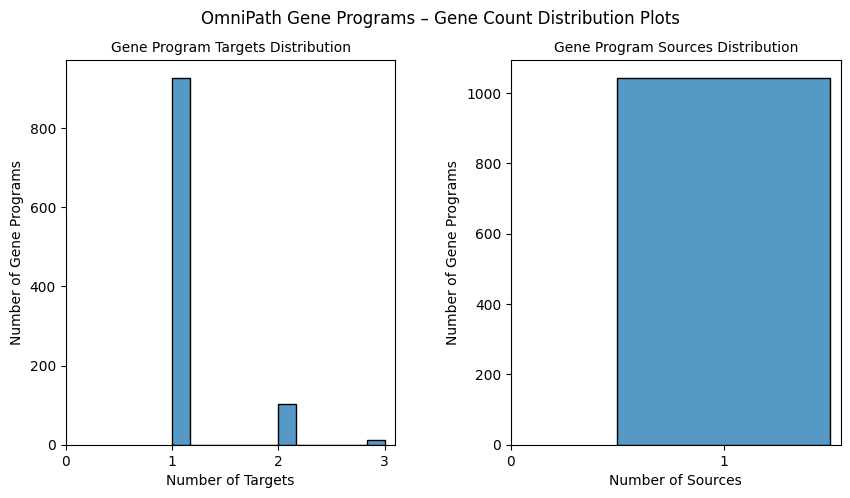

In [9]:
# Retrieve OmniPath GPs (source: ligand genes; target: receptor genes)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=False,
    #lr_network_file_path=omnipath_lr_network_file_path,
    #gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True,
    gp_gene_count_distributions_save_path=f"{figure_folder_path}" \
                                           "/omnipath_gp_gene_count_distributions.svg")

In [10]:
# Display example OmniPath GP
omnipath_gp_names = list(omnipath_gp_dict.keys())
random.shuffle(omnipath_gp_names)
omnipath_gp_name = omnipath_gp_names[0]
print(f"{omnipath_gp_name}: {omnipath_gp_dict[omnipath_gp_name]}")

LEFTY2_ligand_receptor_GP: {'sources': ['LEFTY2'], 'targets': ['TGFB1'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}


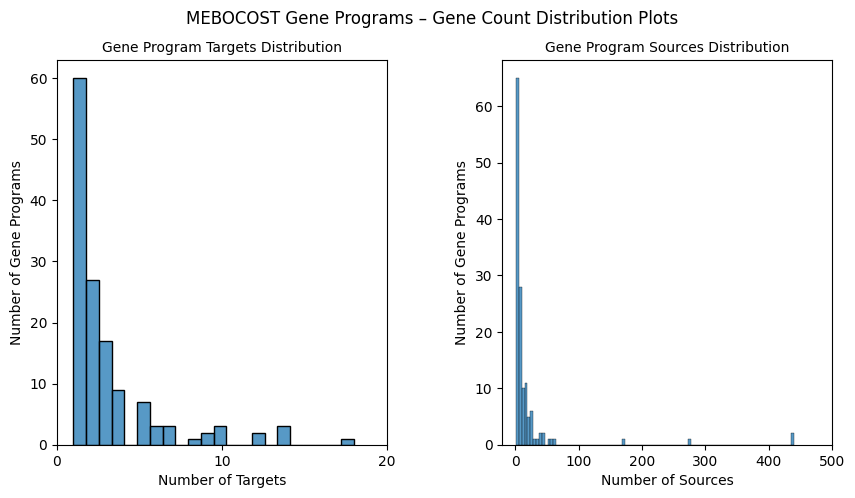

In [11]:
mebocost_enzyme_sensor_interactions_folder_path = '/work/rwth1209/dana_projects/spatial_domain_tools/NicheCompass/nichecompass-reproducibility/datasets/gp_data/metabolite_enzyme_sensor_gps'
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=True)

In [12]:
# Display example MEBOCOST GP
mebocost_gp_names = list(mebocost_gp_dict.keys())
random.shuffle(mebocost_gp_names)
mebocost_gp_name = mebocost_gp_names[0]
print(f"{mebocost_gp_name}: {mebocost_gp_dict[mebocost_gp_name]}")

Phosphate_metabolite_enzyme_sensor_GP: {'sources': ['ACACA', 'ACACB', 'ACLY', 'ACP1', 'ACP2', 'ACP5', 'ACP6', 'ACPL2', 'ACPP', 'ACPT', 'ACYP1', 'ACYP2', 'ADSS', 'ADSSL1', 'AGXT2L1', 'AGXT2L2', 'ALDH18A1', 'ALPI', 'ALPL', 'ALPP', 'ALPPL2', 'ASCC3', 'ATAD1', 'ATAD2', 'ATP13A1', 'ATP13A2', 'ATP13A3', 'ATP13A4', 'ATP13A5', 'ATPBD4', 'ATRX', 'BLM', 'BPGM', 'BPNT1', 'BRIP1', 'CAD', 'CANT1', 'CARKD', 'CARNS1', 'CDC14A', 'CDC14B', 'CDC14C', 'CDC25A', 'CDC25B', 'CDC25C', 'CDKN3', 'CFTR', 'CHD1', 'CHD1L', 'CHD2', 'CHD3', 'CHD4', 'CHD5', 'CHD6', 'CHD7', 'CHD8', 'CHD9', 'CPS1', 'CTDNEP1', 'CTDP1', 'CTDSP1', 'CTDSP2', 'CTDSPL', 'CTPS1', 'CTPS2', 'DCPS', 'DDX1', 'DDX10', 'DDX11', 'DDX11L8', 'DDX12P', 'DDX17', 'DDX18', 'DDX19A', 'DDX19B', 'DDX20', 'DDX21', 'DDX23', 'DDX24', 'DDX25', 'DDX27', 'DDX28', 'DDX31', 'DDX39A', 'DDX39B', 'DDX3X', 'DDX3Y', 'DDX4', 'DDX41', 'DDX42', 'DDX43', 'DDX46', 'DDX47', 'DDX49', 'DDX5', 'DDX50', 'DDX51', 'DDX52', 'DDX53', 'DDX54', 'DDX55', 'DDX56', 'DDX58', 'DDX59', 'DDX6

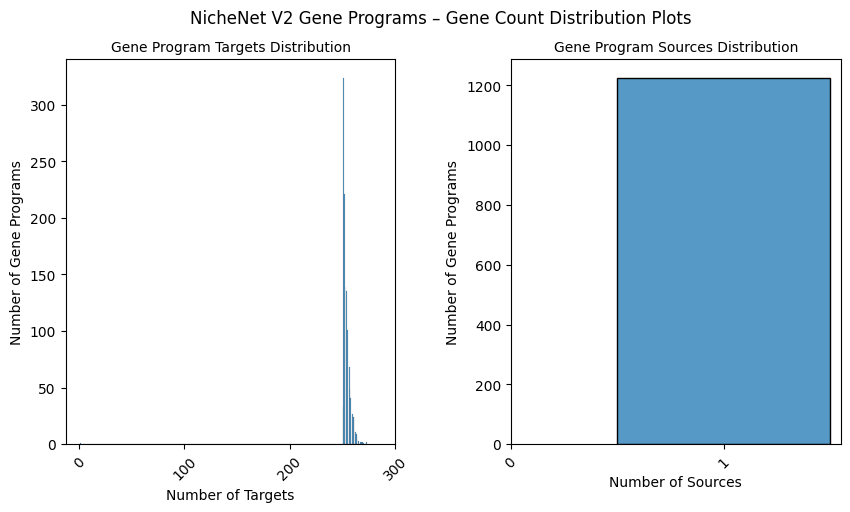

In [13]:
# Retrieve NicheNet GPs (source: ligand genes; target: receptor genes, target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=1.,
    max_n_target_genes_per_gp=250,
    load_from_disk=False,
    save_to_disk=False,
    #lr_network_file_path=nichenet_lr_network_file_path,
    #ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    #gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

In [14]:
# Display example NicheNet GP
nichenet_gp_names = list(nichenet_gp_dict.keys())
random.shuffle(nichenet_gp_names)
nichenet_gp_name = nichenet_gp_names[0]
print(f"{nichenet_gp_name}: {nichenet_gp_dict[nichenet_gp_name]}")

NPPA_ligand_receptor_target_gene_GP: {'sources': ['NPPA'], 'targets': ['NPR1', 'NPR3', 'NPR2', 'ABCA1', 'ABCB1', 'ABCC3', 'ACOT7', 'ACTB', 'ADIPOQ', 'ADM', 'AKAP1', 'ANG', 'ANKRD1', 'APOA1', 'APOB', 'APP', 'AQP2', 'AR', 'ASS1', 'ATF3', 'BAX', 'BCL2', 'BCL2L1', 'BCL3', 'BCL6', 'BDNF', 'BHLHE40', 'BIRC3', 'BIRC5', 'BRCA1', 'BTG2', 'C3', 'CAV1', 'CBX5', 'CCL2', 'CCL20', 'CCL5', 'CCN2', 'CCNA2', 'CCND1', 'CCND2', 'CCND3', 'CD44', 'CD83', 'CDH1', 'CDK6', 'CDKN1A', 'CDKN1B', 'CDX2', 'CEACAM1', 'CEBPB', 'CFB', 'CFLAR', 'CITED2', 'CKS1B', 'CLU', 'CRYAB', 'CSF2', 'CTH', 'CXCL1', 'CXCL10', 'CXCL12', 'CXCL2', 'CXCL8', 'CXCR4', 'CYP1A1', 'CYP1B1', 'DDIT3', 'DDIT4', 'DHRS2', 'DHRS3', 'DKK1', 'DUSP1', 'DUSP5', 'DUSP6', 'E2F1', 'EBI3', 'EDN1', 'EFHD1', 'EFNA1', 'EGFR', 'EGR1', 'EGR3', 'EHD1', 'ELF3', 'EMP1', 'EPAS1', 'EPHA2', 'ESR1', 'F3', 'FAS', 'FKBP5', 'FN1', 'FOS', 'FOSL1', 'FOXA1', 'FST', 'GADD45A', 'GADD45B', 'GADD45G', 'GATA3', 'GATA4', 'GATA6', 'GDF15', 'GEM', 'GREB1', 'GSN', 'H2AC6', 'HAND1'

In [15]:
# Add GPs into one combined dictionary for model training
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)

In [16]:
# Filter and combine GPs to avoid overlaps
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

Number of gene programs before filtering and combining: 2406.
Number of gene programs after filtering and combining: 1987.


In [17]:
# Compute spatial neighborhood
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)

# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

In [18]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_targets_categories_mask_key=gp_targets_categories_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_sources_categories_mask_key=gp_sources_categories_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=2,
    min_source_genes_per_gp=1,
    min_target_genes_per_gp=1,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

In [19]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key=cell_type_key)

Number of nodes (observations): 217184
Number of node features (genes): 500


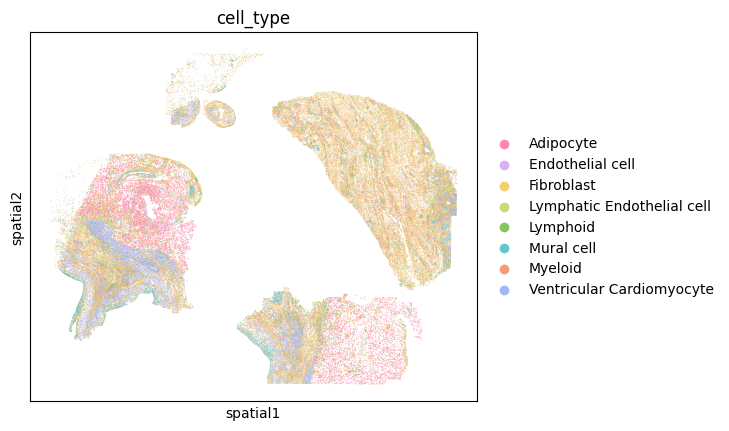

In [20]:
print(f"Number of nodes (observations): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sc.pl.spatial(adata,
              color=cell_type_key,
              palette=cell_type_colors,
              img_key=None,
              spot_size=20)        

In [21]:
# Initialize model
model = NicheCompass(adata,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_targets_categories_mask_key=gp_targets_categories_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     gp_sources_categories_mask_key=gp_sources_categories_mask_key,
                     latent_key=latent_key,
                     conv_layer_encoder=conv_layer_encoder,
                     active_gp_thresh_ratio=active_gp_thresh_ratio,
                     )

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 500, n_cat_covariates_embed_input: 0, n_hidden: 206, n_latent: 106, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0


MASKED TARGET RNA DECODER -> n_prior_gp_input: 106, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 500
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 106, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 500


In [22]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            n_sampled_neighbors=n_sampled_neighbors,
            use_cuda_if_available=use_cuda_if_available,
            verbose=False)


--- INITIALIZING TRAINER ---
Number of training nodes: 195466
Number of validation nodes: 21718
Number of training edges: 3128399
Number of validation edges: 347599
Edge batch size: 1024
Node batch size: None

--- MODEL TRAINING ---


KeyboardInterrupt: 

# Model was trained as a slurm job
# Continuation of analysis

In [40]:
load_timestamp = "12062024_155102_vk12_<3"
# load_timestamp = current_timestamp # uncomment if you trained the model in this notebook

figure_folder_path = f"{artifacts_folder_path}/single_sample/{load_timestamp}/figures"
model_folder_path = f"{artifacts_folder_path}/single_sample/{load_timestamp}/model"

os.makedirs(figure_folder_path, exist_ok=True)

In [41]:
# Load trained model
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name="adata.h5ad",
                          gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 500, n_cat_covariates_embed_input: 0, n_hidden: 206, n_latent: 106, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 106, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 500
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 106, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 500


In [42]:
model.adata.obs

,fov,volume,min_x,min_y,max_x,max_y,anisotropy,transcript_count,perimeter_area_ratio,solidity,...,Cellbound1_high_pass,DAPI_raw,DAPI_high_pass,region,n_counts,leiden_0_5,leiden_1,leiden_1_5,tacco,cell_type
3325265900001100060,23,469.185540,8438.481700,9873.034558,8444.527629,9883.167257,1.978525,3,0.616233,6.605239,...,1.750160e+05,2.550569e+07,4.059211e+05,0,3.0,6,12,15,Fibroblast,Mural cell
3325265900002100001,22,2886.628438,8857.740244,9573.972300,8872.406847,9601.736165,1.945604,27,0.275619,5.914615,...,9.769555e+05,1.005999e+09,1.506097e+07,0,27.0,6,12,15,Fibroblast,Mural cell
3325265900002100002,22,2579.211312,8870.218588,9574.055711,8886.064568,9596.320409,1.491581,16,0.247222,6.753856,...,7.757270e+05,9.056469e+08,1.231255e+07,0,16.0,6,12,15,Fibroblast,Mural cell
3325265900002100007,22,1320.019062,8888.215800,9582.861523,8900.279321,9597.083624,1.183200,5,0.328241,6.891664,...,5.019835e+05,2.907988e+08,4.554542e+06,0,5.0,6,30,35,Fibroblast,Mural cell
3325265900002100009,22,1609.002058,8850.977646,9587.223310,8862.910012,9604.361235,1.415872,5,0.302887,6.924438,...,3.834036e+05,4.897006e+08,5.772209e+06,0,3.0,6,12,15,Fibroblast,Mural cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3325268800171100158,2450,1048.352399,1637.162880,11271.543084,1650.310945,11283.536428,1.165992,32,0.393974,6.597903,...,7.040203e+05,7.527711e+07,1.266227e+06,3,32.0,6,12,15,Ventricular Cardiomyocyte,Mural cell
3325268800171100163,2449,216.193848,1617.489601,11275.924214,1624.759867,11281.315174,2.304225,22,0.941618,6.561603,...,2.078765e+05,2.753600e+07,3.252925e+05,3,21.0,1,8,3,Fibroblast,Fibroblast
3325268800171100167,2450,1608.858523,1627.009311,11284.049632,1641.582483,11298.187850,1.198896,16,0.304226,6.799355,...,1.323398e+06,7.431608e+08,8.160573e+06,3,16.0,6,12,15,Ventricular Cardiomyocyte,Mural cell
3325268800171100171,2450,680.650653,1623.905173,11299.376840,1634.152356,11308.556754,1.437629,16,0.472838,6.868844,...,4.632065e+05,4.129646e+07,7.217144e+05,3,16.0,6,12,15,Mural cell,Mural cell


In [43]:
model.adata

AnnData object with n_obs × n_vars = 217184 × 500
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Cellbound2_raw', 'Cellbound2_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'region', 'n_counts', 'leiden_0_5', 'leiden_1', 'leiden_1_5', 'tacco', 'cell_type'
    var: 'mean', 'std'
    uns: 'cell_type_colors', 'leiden', 'leiden_0_5_colors', 'leiden_1_5_colors', 'leiden_1_colors', 'log1p', 'neighbors', 'nichecompass_active_gp_names', 'nichecompass_genes_idx', 'nichecompass_gp_names', 'nichecompass_latent', 'nichecompass_source_genes_idx', 'nichecompass_sources_categories_label_encoder', 'nichecompass_target_genes_idx', 'nichecompass_targets_categories_label_encoder', 'pca', 'rank_genes_groups', 'spatial', 'spatial_neighbors', 'tacco_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'blank_genes', 'nich

In [44]:
samples = model.adata.obs['region'].unique().tolist()

In [45]:
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=cell_type_key)

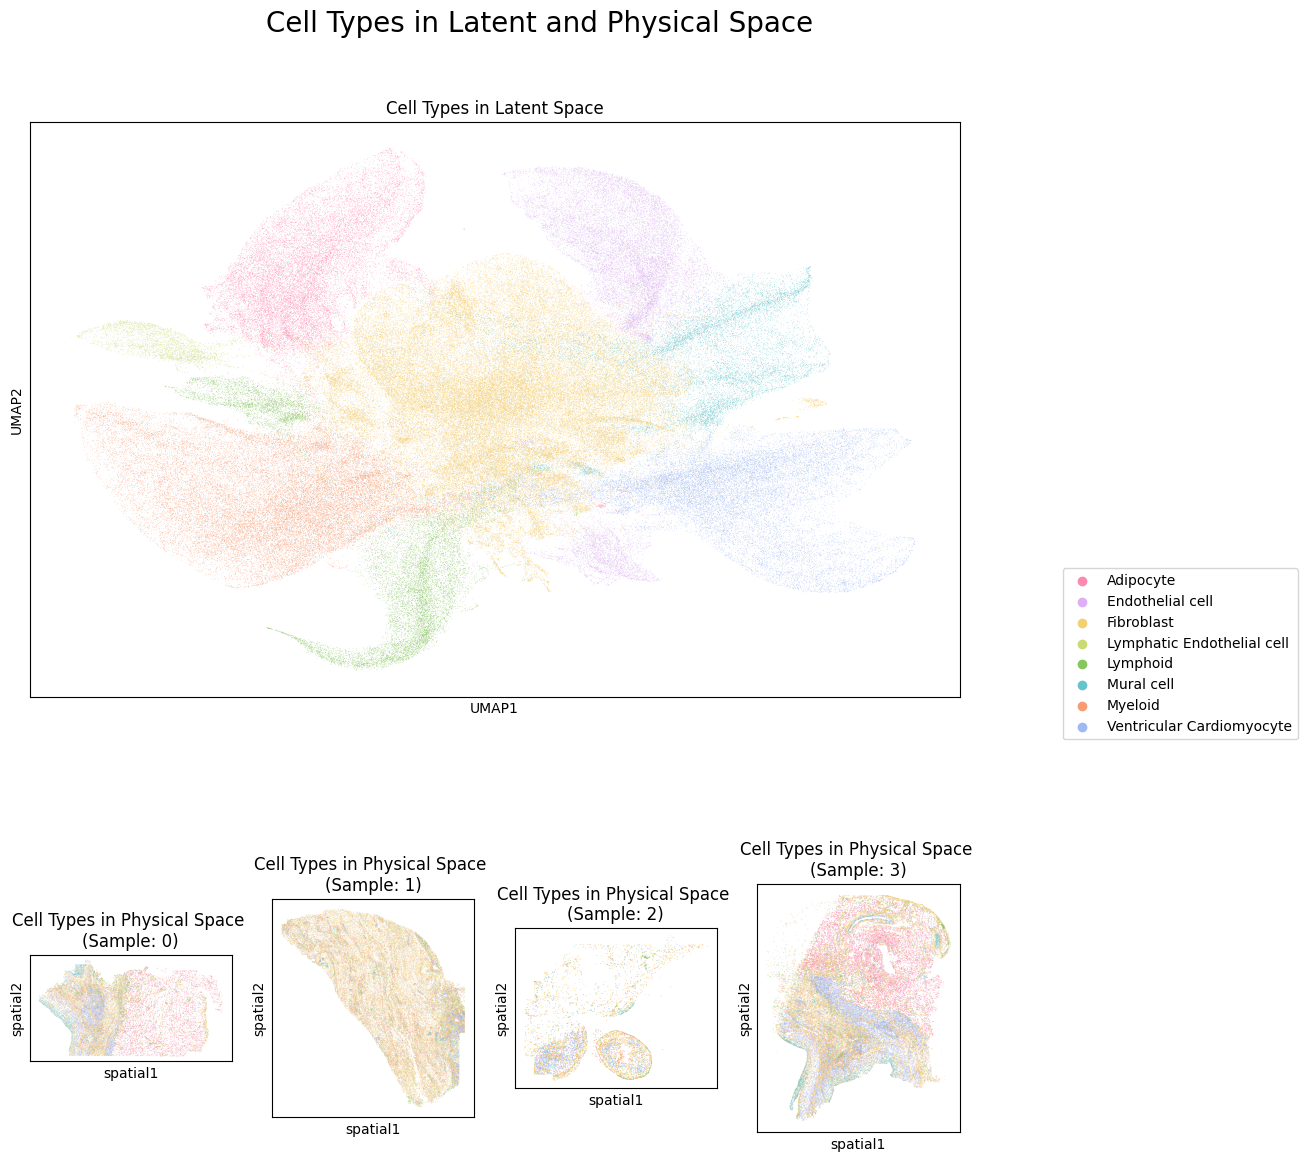

In [46]:
# Create plot of cell type annotations in physical and latent space
groups = None
save_fig = True
file_path = f"{figure_folder_path}/" \
            "cell_types_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"Cell Types " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           groups=groups,palette=cell_type_colors,
           title=f"Cell Types in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[cell_type_key],
                  groups=groups,
                  img_key=None,
                  palette=cell_type_colors,
                  spot_size=15,
                  title=f"Cell Types in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

# 4.2 Identify Niches

In [47]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [48]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)

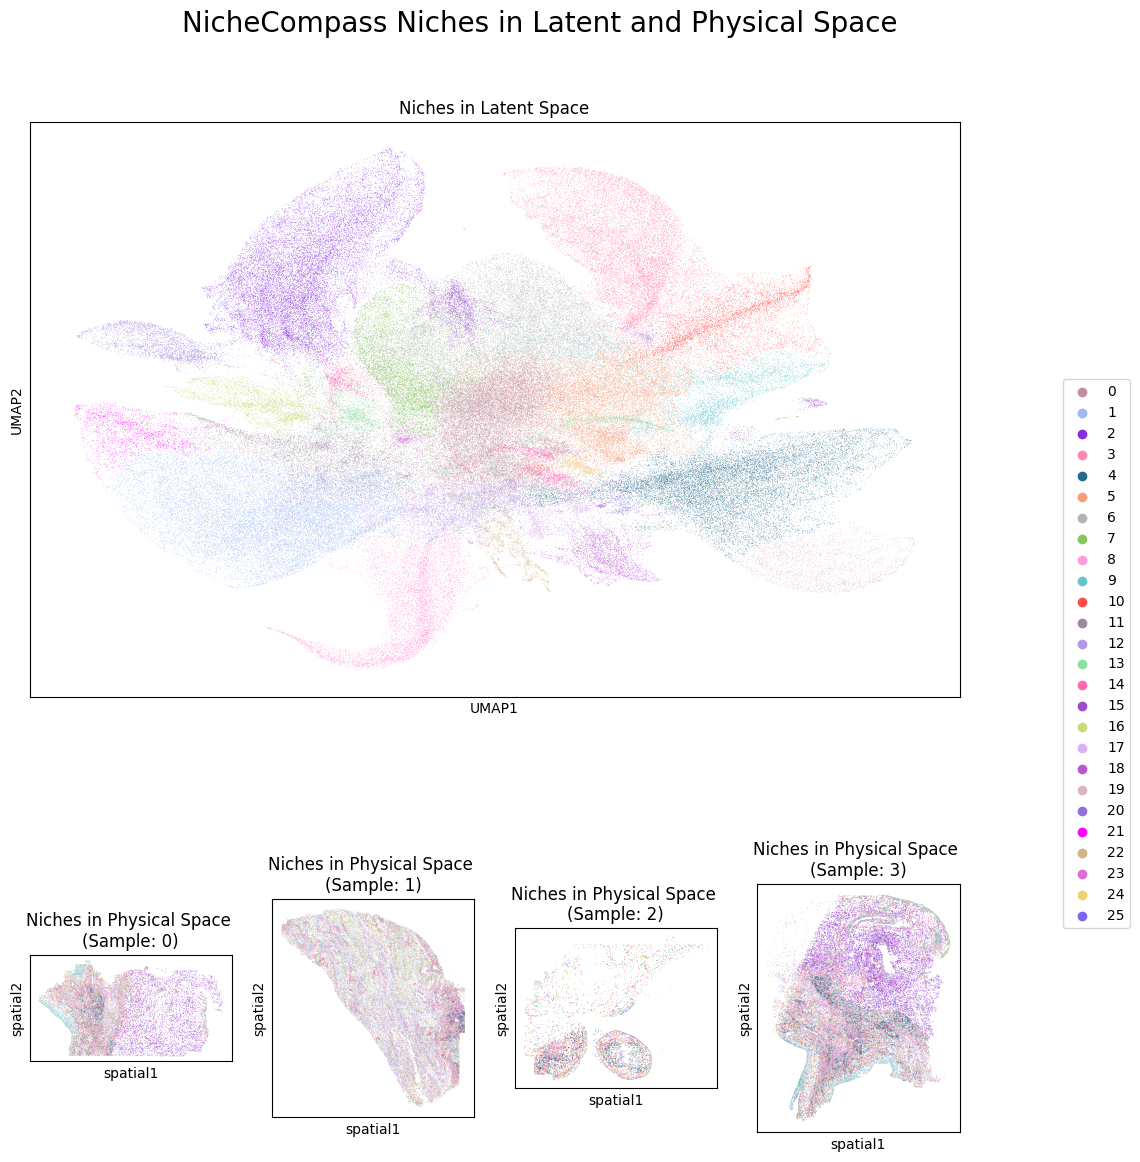

In [49]:
# Create plot of latent cluster / niche annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["17"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "niches_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Niches " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           palette=latent_cluster_colors,
           title=f"Niches in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[latent_cluster_key],
                  groups=groups,
                  img_key=None,
                  palette=latent_cluster_colors,
                  spot_size=15,
                  title=f"Niches in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

## 4.3.1 Niche Composition

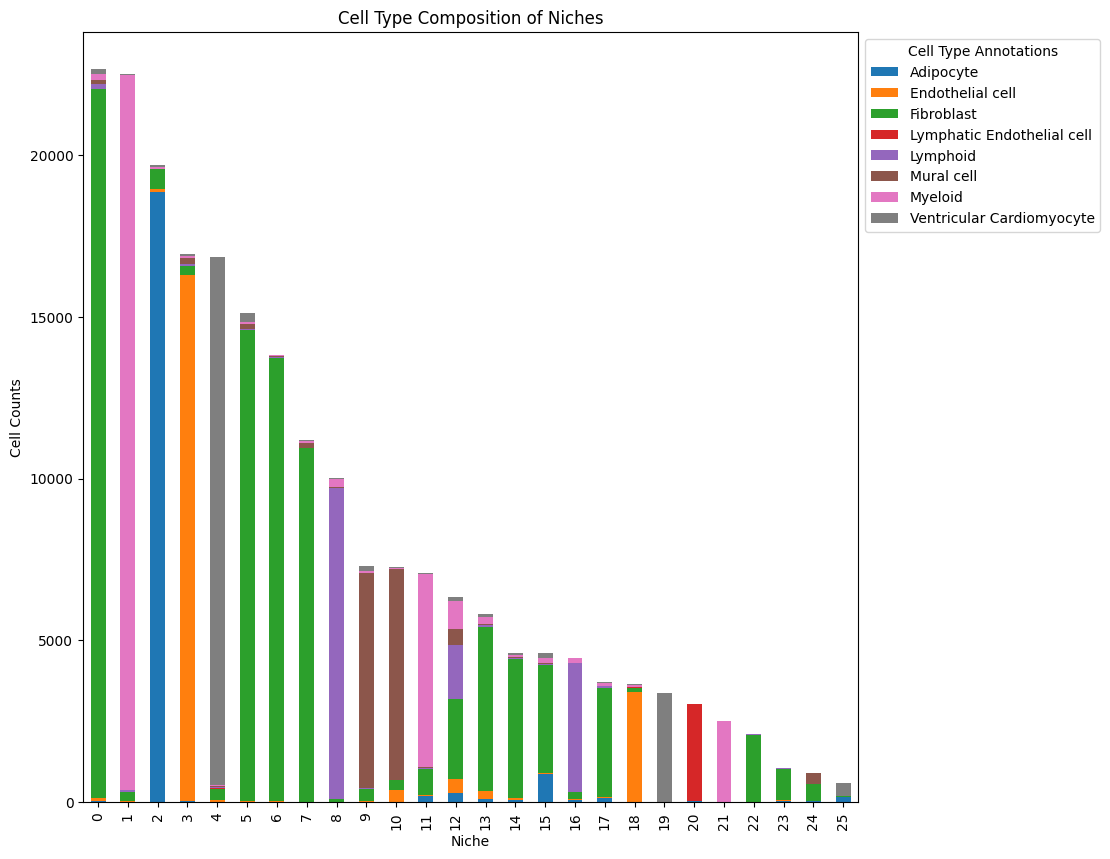

In [50]:
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_composition.svg"

df_counts = (model.adata.obs.groupby([latent_cluster_key, cell_type_key])
             .size().unstack())
df_counts.plot(kind="bar", stacked=True, figsize=(10,10))
legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={'size': 10})
legend.set_title("Cell Type Annotations", prop={'size': 10})
plt.title("Cell Type Composition of Niches")
plt.xlabel("Niche")
plt.ylabel("Cell Counts")
if save_fig:
    plt.savefig(file_path,
                bbox_extra_artists=(legend,),
                bbox_inches="tight")

In [51]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 206.
Number of active gene programs: 206.


In [52]:
# Display example active GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

,gp_name,all_gp_idx,gp_active,active_gp_idx,n_source_genes,n_non_zero_source_genes,n_target_genes,n_non_zero_target_genes,gp_source_genes,gp_target_genes,gp_source_genes_weights,gp_target_genes_weights,gp_source_genes_importances,gp_target_genes_importances
0,CCL4_ligand_receptor_GP,0,True,0,1,1,1,1,[CCL4],[PLCB1],[-0.051],[-0.0929],[0.3544],[0.6456]
1,EFNA5_ligand_receptor_GP,1,True,1,1,1,1,1,[EFNA5],[FYN],[0.0233],[-0.1352],[0.1472],[0.8528]
2,FGF12_ligand_receptor_GP,2,True,2,1,1,1,1,[FGF12],[PDGFRA],[0.0161],[-0.0629],[0.2037],[0.7963]
3,COMP_ligand_receptor_GP,3,True,3,1,1,1,1,[COMP],[ITGA8],[0.1959],[0.0186],[0.9132],[0.0868]
4,L-Tyrosine_metabolite_enzyme_sensor_GP,4,True,4,2,2,1,1,"[TPO, TH]",[SLC16A10],"[-0.114, -0.0418]",[-0.0486],"[0.5579, 0.2045]",[0.2377]


In [53]:
# Set parameters for differential gp testing
selected_cats = None
comparison_cats = "rest"
title = f"NicheCompass Strongly Enriched Niche GPs"
log_bayes_factor_thresh = 2.3
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_niches_enriched_gps_heatmap.svg"

In [54]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [55]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

,category,gene_program,p_h0,p_h1,log_bayes_factor
0,19,FGF14_ligand_receptor_target_gene_GP,0.999820,0.000180,8.620291
1,20,CCL21_ligand_receptor_target_gene_GP,0.000304,0.999696,-8.097175
2,18,A2M_ligand_receptor_target_gene_GP,0.999682,0.000318,8.053033
3,19,PAM_ligand_receptor_target_gene_GP,0.999608,0.000392,7.844960
4,22,CDH13_ligand_receptor_target_gene_GP,0.999296,0.000704,7.258064
...,...,...,...,...,...
328,3,A2M_ligand_receptor_target_gene_GP,0.090540,0.909460,-2.307054
329,19,Add-on_68_GP,0.909456,0.090544,2.307010
330,18,Add-on_53_GP,0.090574,0.909426,-2.306651
331,19,EFNA5_ligand_receptor_GP,0.090654,0.909346,-2.305671


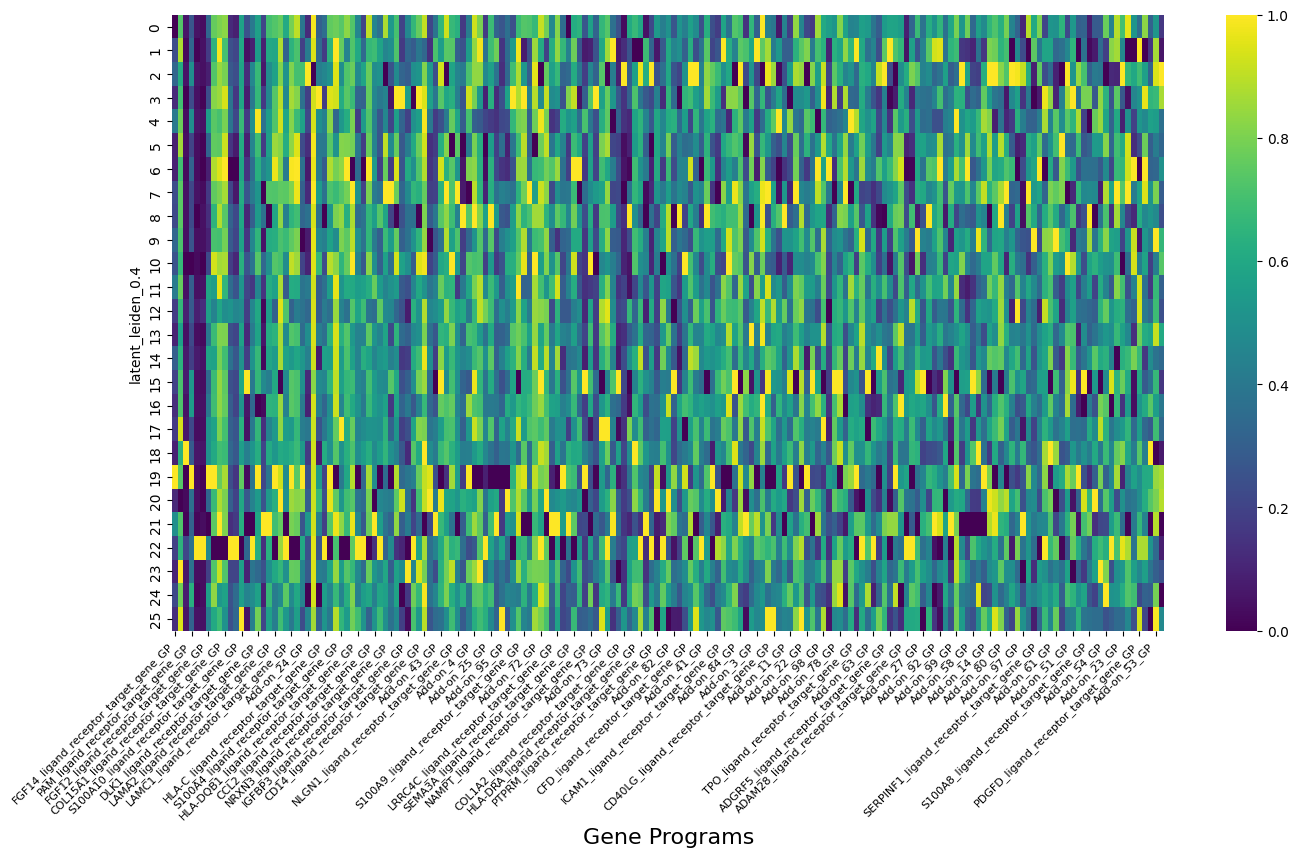

In [56]:
# Visualize GP activities of enriched GPs across niches
df = model.adata.obs[[latent_cluster_key] + enriched_gps].groupby(latent_cluster_key).mean()

scaler = MinMaxScaler()
normalized_columns = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
normalized_df.index = df.index

plt.figure(figsize=(16, 8))  # Set the figure size
ax = sns.heatmap(normalized_df,
            cmap='viridis',
            annot=False,
            linewidths=0)
plt.xticks(rotation=45,
           fontsize=8,
           ha="right"
          )
plt.xlabel("Gene Programs", fontsize=16)
plt.savefig(f"{figure_folder_path}/enriched_gps_heatmap.svg",
            bbox_inches="tight")

In [57]:
# Store gene program summary of enriched gene programs
save_file = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
            "niche_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]

enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

In [58]:
plot_label = f"log_bayes_factor_{log_bayes_factor_thresh}_cluster_{selected_cats[0]}_vs_rest"
save_figs = True

generate_enriched_gp_info_plots(
    plot_label=plot_label,
    model=model,
    sample_key=sample_key,
    differential_gp_test_results_key=differential_gp_test_results_key,
    cat_key=latent_cluster_key,
    cat_palette=latent_cluster_colors,
    n_top_enriched_gp_start_idx=0,
    n_top_enriched_gp_end_idx=10,
    feature_spaces=samples, # ["latent"]
    n_top_genes_per_gp=3,
    save_figs=save_figs,
    figure_folder_path=f"{figure_folder_path}/",
    spot_size=spot_size)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# 4.3.3 Cell-cell Communication

In [59]:
gp_name = "PAM_ligand_receptor_target_gene_GP"

In [60]:
network_df = compute_communication_gp_network(
    gp_list=[gp_name],
    model=model,
    group_key=latent_cluster_key,
    n_neighbors=n_neighbors)

visualize_communication_gp_network(
    adata=model.adata,
    network_df=network_df,
    figsize=(3, 7),
    cat_colors=latent_cluster_colors,
    edge_type_colors=["#1f77b4"], 
    cat_key=latent_cluster_key,
    save=True,
    save_path=f"{figure_folder_path}/gp_network_{gp_name}.svg",
    )

: 